# Feature importance for Druggable peptides using the best model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# remove warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,f1_score, recall_score, precision_score
from sklearn.utils import class_weight

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel, SelectPercentile, f_classif

import seaborn as sns; sns.set() # data visualization library 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from imblearn.over_sampling import SMOTE

from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
import numpy as np

import pandas as pd
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib

print(__doc__)

2024-06-05 16:30:27,876 [12864] WARNING  py.warnings:110: [JupyterRequire] c:\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)



Automatically created module for IPython interactive environment


In [2]:
def DataCheckings(df):
    # CHECKINGS ***************************
    # Check the number of data points in the data set
    print("\nData points =", len(df))
    
    # Check the number of columns in the data set
    print("\nColumns (output + features)=",len(df.columns))
    
    # Check the data types
    print("\nData types =", df.dtypes.unique())
    
    # Dataset statistics
    print('\n')
    df.describe()
    
    # print names of columns
    print('Column Names:\n', df.columns)
    
    # see if there are categorical data
    print("\nCategorical features:", df.select_dtypes(include=['O']).columns.tolist())
    
    # Check NA values
    # Check any number of columns with NaN
    print("\nColumns with NaN: ", df.isnull().any().sum(), ' / ', len(df.columns))

    # Check any number of data points with NaN
    print("\nNo of data points with NaN:", df.isnull().any(axis=1).sum(), ' / ', len(df))

In [3]:
def getDataFromDataset(sFile, OutVar):
    # read details file
    print('\n-> Read dataset', sFile)
    df = pd.read_csv(sFile)
    #df = feather.read_dataframe(sFile)
    
    DataCheckings(df)
    
    # remove duplicates!
    df.drop_duplicates(keep=False, inplace=True)
    
    print('Shape', df.shape)
    # print(list(df.columns))

    # select X and Y
    ds_y = df[OutVar]
    ds_X = df.drop(OutVar,axis = 1)
    Xdata = ds_X.values # get values of features
    Ydata = ds_y.values # get output values

    print('Shape X data:', Xdata.shape)
    print('Shape Y data:',Ydata.shape)
    
    # return data for X and Y, feature names as list
    return (Xdata, Ydata, list(ds_X.columns))

In [4]:
def  set_weights(y_data, option='balanced'):
    """Estimate class weights for umbalanced dataset
       If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)). 
       If a dictionary is given, keys are classes and values are corresponding class weights. 
       If None is given, the class weights will be uniform """
    cw = class_weight.compute_class_weight(option, np.unique(y_data), y_data)
    w = {i:j for i,j in zip(np.unique(y_data), cw)}
    return w 

In [18]:
# define output variables
outVar = 'Class'

# define list of folds
foldType = 3

# define a label for output files
targetName = 'GS_Outer'

seed = 28

## Reproduce the pipeline model

In [6]:
sFile = './datasets/ds.Class_TC_ballanced.csv'

# get data from file
Xdata, Ydata, Features = getDataFromDataset(sFile,outVar) # n_sample=100


-> Read dataset ./datasets/ds.Class_TC_ballanced.csv

Data points = 1332

Columns (output + features)= 8001

Data types = [dtype('float64') dtype('int64')]


Column Names:
 Index(['AAA', 'RAA', 'NAA', 'DAA', 'CAA', 'EAA', 'QAA', 'GAA', 'HAA', 'IAA',
       ...
       'KVV', 'MVV', 'FVV', 'PVV', 'SVV', 'TVV', 'WVV', 'YVV', 'VVV', 'Class'],
      dtype='object', length=8001)

Categorical features: []

Columns with NaN:  0  /  8001

No of data points with NaN: 0  /  1332
Shape (1332, 8001)
Shape X data: (1332, 8000)
Shape Y data: (1332,)


In [7]:
# Calculate class weights
class_weights = set_weights(Ydata)
print("Class weights = ", class_weights)

Class weights =  {0: 1.0, 1: 1.0}


In [8]:
outer_cv = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)

In [9]:
ifold = 0
ACCs  =[]
AUROCs=[]
models =[]
SelectedFeatures =[]

for train_index, test_index in outer_cv.split(Xdata, Ydata):
    ifold +=1
    
    print("Fold =",ifold)
    start = time.time()
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = Xdata[train_index], Xdata[test_index]
    y_train, y_test = Ydata[train_index], Ydata[test_index]
    
    # Standardize dataset
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    
    # Feature selection # FS = SelectFromModel(LinearSVC(), max_features = 400,threshold=-np.inf)
    lsvc = LinearSVC(max_iter=50000).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True,max_features = 200,threshold=-np.inf)
    X_train = model.transform(X_train)
    X_test  = model.transform(X_test)
    #print("Selected X:", X_train.shape)

    # Selected features
    SelFeatures = []
    for i in model.get_support(indices=True):
        SelFeatures.append(Features[i])
    SelectedFeatures.append(SelFeatures)

    #scaler.transform(X_test)
    clf = SVC(kernel = 'rbf', random_state=seed,gamma='scale',
              class_weight=class_weights,probability=True)
    clf.fit(X_train, y_train)
    
    joblib.dump(clf, 'SVM_model'+str(ifold)+'.pkl', compress = 1)
    models.append(clf)
    
    y_pred = clf.predict_proba(X_test)
    AUROC = roc_auc_score(y_test, y_pred[:, 1])
    AUROCs.append(AUROC)
    
    ACC = clf.score(X_test,y_test)
    ACCs.append(ACC)
   
    print("AUROC=",AUROC,"ACC=",ACC, (time.time() - start)/60,"mins")
    

Fold = 1
AUROC= 0.9707410112815518 ACC= 0.9301801801801802 2.053646918137868 mins
Fold = 2
AUROC= 0.9752049346643942 ACC= 0.9369369369369369 1.0309011777242025 mins
Fold = 3
AUROC= 0.9783499715932148 ACC= 0.9211711711711712 1.037073588371277 mins


Let's see the mean AUROC values for best model and the standard deviations:

In [10]:
print(np.mean(AUROCs),np.std(AUROCs))

0.974765305846387 0.0031218610239548486


In [11]:
print(np.mean(ACCs),np.std(ACCs))

0.9294294294294295 0.006458202152434386


In [12]:
# all the selected features for the 3 folds
print(SelectedFeatures)

[['NRA', 'LDA', 'KCA', 'EHA', 'THA', 'VIA', 'YLA', 'IMA', 'CSA', 'VYA', 'KNR', 'TDR', 'WDR', 'TER', 'PQR', 'WMR', 'PPR', 'RSR', 'VSR', 'ETR', 'FWR', 'NYR', 'PVR', 'NAN', 'YNN', 'YIN', 'FMN', 'HFN', 'HDD', 'SDD', 'ACD', 'MED', 'WED', 'TQD', 'SHD', 'WLD', 'VFD', 'WPD', 'SSD', 'LTD', 'PWD', 'EYD', 'VYD', 'WRC', 'TGC', 'IHC', 'WHC', 'VHC', 'WLC', 'GMC', 'GFC', 'GYC', 'EVC', 'GDE', 'SDE', 'SQE', 'IGE', 'NHE', 'NME', 'HME', 'YPE', 'TSE', 'AWE', 'EYE', 'QYE', 'SAQ', 'MRQ', 'INQ', 'PCQ', 'WEQ', 'AQQ', 'RQQ', 'KQQ', 'NGQ', 'CHQ', 'HLQ', 'HKQ', 'DSQ', 'FVQ', 'CDG', 'HGG', 'KGG', 'FGG', 'FPG', 'AWG', 'RVG', 'IVG', 'PAH', 'PDH', 'TQH', 'DGH', 'CGH', 'KHH', 'FWH', 'TYH', 'LVH', 'PAI', 'QNI', 'WEI', 'ESI', 'AYI', 'DRL', 'PDL', 'GPL', 'WYL', 'DVL', 'MVL', 'QRK', 'HNK', 'HCK', 'PHK', 'CIK', 'QLK', 'SMK', 'HTK', 'VYK', 'DVK', 'WRM', 'REM', 'FEM', 'WQM', 'DHM', 'SHM', 'LLM', 'TPM', 'KYM', 'IVM', 'WVM', 'YVM', 'CNF', 'LDF', 'SEF', 'EQF', 'YQF', 'VGF', 'YKF', 'AFF', 'CFF', 'FWF', 'CNP', 'QGP', 'PIP', 'AKP

In [13]:
# differences of selected descriptors
print(list(set(SelectedFeatures[1])-set(SelectedFeatures[0])))

['AVK', 'NKG', 'CHY', 'EKL', 'RWM', 'HGV', 'NFM', 'QSN', 'WHV', 'CHD', 'WSH', 'FHH', 'HVM', 'NDC', 'NSH', 'SSS', 'RSN', 'GYM', 'MLD', 'YAV', 'FNP', 'LWS', 'FEI', 'NPP', 'PSS', 'HGF', 'LIR', 'NDI', 'TTP', 'ERN', 'DHK', 'ESL', 'HDS', 'GNK', 'FDH', 'HKP', 'SMM', 'FYT', 'FNQ', 'HTD', 'CDH', 'YSQ', 'YGR', 'ALE', 'HDK', 'CLT', 'LPE', 'MCA', 'IKL', 'FFN', 'SSG', 'EWK', 'LHN', 'WNM', 'SQP', 'GEV', 'AWQ', 'DMY', 'FKL', 'INA', 'KLG', 'SHS', 'QGW', 'DFQ', 'YTT', 'QYV', 'DSV', 'IRT', 'FWN', 'FVE', 'RTG', 'GPQ', 'MGI', 'WQI', 'VYM', 'EQK', 'STP', 'KCW', 'LLV', 'VHP', 'MCE', 'HVW', 'NGF', 'TSM', 'SMD', 'WDS', 'LAT', 'WRI', 'SDN', 'FFK', 'QRA', 'TSV', 'GVE', 'RMQ', 'EHR', 'QSK', 'KKT', 'FAP', 'RVQ', 'VVL', 'WCD', 'TGG', 'ENV', 'QRG', 'IFH', 'YEA', 'DWD', 'EKK', 'MDN', 'PTG', 'PLP', 'MDQ', 'PEP', 'KVW', 'IKW', 'IMV', 'KNC', 'EDI', 'AAL', 'PMI']


In [14]:
# differences of selected descriptors
print(list(set(SelectedFeatures[1])-set(SelectedFeatures[2])))

['PQR', 'AVK', 'THA', 'CHY', 'RWM', 'NFM', 'IVG', 'QSN', 'WHV', 'CHD', 'WSH', 'FHH', 'HVM', 'NSH', 'QPP', 'FPG', 'SSS', 'GYM', 'MLD', 'LWS', 'FEI', 'NPP', 'PSS', 'HGF', 'NDI', 'WDR', 'DHK', 'ESL', 'HDS', 'GNK', 'VSR', 'HKP', 'SMM', 'FYT', 'FNQ', 'HTD', 'CDH', 'YSQ', 'YGR', 'ALE', 'HDK', 'TQH', 'CLT', 'KNR', 'LPE', 'MCA', 'IKL', 'FFN', 'SSG', 'EWK', 'LHN', 'SQP', 'VGW', 'AWQ', 'GEV', 'FKL', 'INA', 'QGW', 'DFQ', 'YTT', 'QYV', 'DSV', 'IRT', 'FWN', 'PCQ', 'ACD', 'FVE', 'MGI', 'WQI', 'VYM', 'EQK', 'STP', 'KCW', 'QGV', 'VHP', 'MCE', 'HVW', 'NGF', 'SMD', 'WDS', 'LAT', 'SDN', 'FFK', 'QRA', 'KYM', 'TSV', 'RMQ', 'QSK', 'FAP', 'FWH', 'WCD', 'TGG', 'CSA', 'QRG', 'IFH', 'EKK', 'AWE', 'PTG', 'MDQ', 'PEP', 'KVW', 'IMV', 'KNC', 'EDI', 'AAL', 'NHE', 'MED']


## Predictions with the best model

We choose model 2 as the best due to the maximum ACC value (AUROC= 0.9752, ACC= 0.937).

In [16]:
# the selected features for model 2
print(SelectedFeatures[1])

['NRA', 'QRA', 'INA', 'MCA', 'YEA', 'THA', 'CSA', 'VYA', 'KNR', 'WDR', 'TER', 'PQR', 'YGR', 'EHR', 'LIR', 'VSR', 'ERN', 'MDN', 'SDN', 'LHN', 'YIN', 'FFN', 'RSN', 'QSN', 'FWN', 'ACD', 'WCD', 'MED', 'CHD', 'SHD', 'MLD', 'SMD', 'WPD', 'SSD', 'HTD', 'DWD', 'VYD', 'KNC', 'NDC', 'IHC', 'VHC', 'GYC', 'MCE', 'NHE', 'ALE', 'HME', 'LPE', 'AWE', 'EYE', 'QYE', 'GVE', 'FVE', 'SAQ', 'FNQ', 'MDQ', 'PCQ', 'WEQ', 'RQQ', 'NGQ', 'HLQ', 'RMQ', 'DFQ', 'GPQ', 'DSQ', 'YSQ', 'AWQ', 'RVQ', 'QRG', 'HGG', 'TGG', 'KLG', 'NKG', 'FPG', 'SSG', 'RTG', 'PTG', 'IVG', 'CDH', 'FDH', 'PDH', 'TQH', 'KHH', 'FHH', 'IFH', 'NSH', 'WSH', 'FWH', 'WRI', 'NDI', 'EDI', 'FEI', 'WEI', 'WQI', 'MGI', 'PMI', 'AAL', 'EKL', 'IKL', 'FKL', 'GPL', 'ESL', 'DVL', 'MVL', 'VVL', 'GNK', 'HNK', 'HDK', 'HCK', 'EQK', 'DHK', 'QLK', 'EKK', 'SMK', 'FFK', 'QSK', 'EWK', 'AVK', 'WRM', 'WNM', 'REM', 'WQM', 'SHM', 'LLM', 'SMM', 'NFM', 'TSM', 'RWM', 'GYM', 'KYM', 'VYM', 'HVM', 'IVM', 'LDF', 'YQF', 'NGF', 'HGF', 'FWF', 'FAP', 'FNP', 'PEP', 'SQP', 'QGP', 'VHP'

Load the prediction datasets (the same format as the dataset: 8000 TC features + Class=-1):

In [68]:
# get data from files and check the files
sFile1 = './datasets/ds.Screening_1_TC.csv'
Xdata1, Ydata1, Features1 = getDataFromDataset(sFile1,outVar) 

sFile2 = './datasets/ds.Screening_2_TC.csv'
Xdata2, Ydata2, Features2 = getDataFromDataset(sFile2,outVar) 

sFile3 = './datasets/ds.Screening_3_TC.csv'
Xdata3, Ydata3, Features3 = getDataFromDataset(sFile3,outVar)

print(Xdata2.shape,Xdata3.shape)


-> Read dataset ./datasets/ds.Screening_1_TC.csv

Data points = 2359

Columns (output + features)= 8001

Data types = [dtype('float64') dtype('int64')]


Column Names:
 Index(['AAA', 'RAA', 'NAA', 'DAA', 'CAA', 'EAA', 'QAA', 'GAA', 'HAA', 'IAA',
       ...
       'KVV', 'MVV', 'FVV', 'PVV', 'SVV', 'TVV', 'WVV', 'YVV', 'VVV', 'Class'],
      dtype='object', length=8001)

Categorical features: []

Columns with NaN:  0  /  8001

No of data points with NaN: 0  /  2359
Shape (2353, 8001)
Shape X data: (2353, 8000)
Shape Y data: (2353,)

-> Read dataset ./datasets/ds.Screening_2_TC.csv

Data points = 231

Columns (output + features)= 8001

Data types = [dtype('float64') dtype('int64')]


Column Names:
 Index(['AAA', 'RAA', 'NAA', 'DAA', 'CAA', 'EAA', 'QAA', 'GAA', 'HAA', 'IAA',
       ...
       'KVV', 'MVV', 'FVV', 'PVV', 'SVV', 'TVV', 'WVV', 'YVV', 'VVV', 'Class'],
      dtype='object', length=8001)

Categorical features: []

Columns with NaN:  0  /  8001

No of data points with NaN: 0  /

Use only the second split / model - scale the prediction datasets, select only the features of model 2, predict the class and predict the probability of that class:

In [13]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from shap import KernelExplainer


In [24]:
def evaluate_feature_importance(X, y, model):
    """
    Evaluates the feature importance of a given classifier model.
    
    Parameters:
    X (numpy.ndarray): The input data.
    y (numpy.ndarray): The target variable.
    model (sklearn.base.BaseEstimator): The classifier model to evaluate.
    
    Returns:
    numpy.ndarray: The feature importance scores.
    """
    # Fit the model
    model.fit(X, y)
    
    # Compute the feature importance using permutation importance
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    
    return result.importances_mean

In [25]:
ifold = 0

for train_index, test_index in outer_cv.split(Xdata, Ydata):
    ifold +=1
    
    if ifold ==2: # only model 2
        print("Fold =",ifold)
        start = time.time()

        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = Xdata[train_index], Xdata[test_index]
        y_train, y_test = Ydata[train_index], Ydata[test_index]

        # Standardize dataset
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)
        
        # Feature selection # FS = SelectFromModel(LinearSVC(), max_features = 400,threshold=-np.inf)
        lsvc = LinearSVC(max_iter=50000).fit(X_train, y_train)
        model = SelectFromModel(lsvc, prefit=True,max_features = 200,threshold=-np.inf)
        X_train = model.transform(X_train)
        X_test  = model.transform(X_test)
    
        # Selected features
        SelFeatures = []
        for i in model.get_support(indices=True):
            SelFeatures.append(Features[i])
        

        # load the saved model from disk
        svc_model = SVC(kernel = 'rbf', random_state=seed,gamma='scale',
                        class_weight=class_weights,probability=True)
        
        feature_importance = evaluate_feature_importance(X_train, y_train, svc_model)

        print("Feature Importance Scores:")
        for i, score in enumerate(feature_importance):
            print(f"Feature {i}: {score:.4f}")

        print("Time",(time.time() - start)/60,"mins")

Fold = 2
Feature Importance Scores:
Feature 0: 0.0003
Feature 1: 0.0002
Feature 2: 0.0001
Feature 3: 0.0000
Feature 4: -0.0005
Feature 5: 0.0000
Feature 6: 0.0000
Feature 7: -0.0006
Feature 8: 0.0002
Feature 9: 0.0000
Feature 10: 0.0007
Feature 11: -0.0005
Feature 12: 0.0002
Feature 13: -0.0005
Feature 14: 0.0008
Feature 15: -0.0006
Feature 16: 0.0021
Feature 17: 0.0007
Feature 18: 0.0007
Feature 19: -0.0006
Feature 20: 0.0003
Feature 21: 0.0020
Feature 22: 0.0005
Feature 23: -0.0006
Feature 24: 0.0000
Feature 25: 0.0002
Feature 26: 0.0005
Feature 27: 0.0000
Feature 28: 0.0008
Feature 29: 0.0000
Feature 30: 0.0001
Feature 31: 0.0000
Feature 32: 0.0001
Feature 33: -0.0002
Feature 34: 0.0027
Feature 35: -0.0006
Feature 36: 0.0020
Feature 37: 0.0007
Feature 38: 0.0016
Feature 39: 0.0006
Feature 40: 0.0006
Feature 41: 0.0015
Feature 42: 0.0010
Feature 43: 0.0010
Feature 44: 0.0007
Feature 45: 0.0073
Feature 46: 0.0005
Feature 47: 0.0007
Feature 48: -0.0005
Feature 49: -0.0001
Feature 50: 0

Hf with ML!@muntisa

In [29]:
df_feature_importance = pd.DataFrame(feature_importance, columns=['Importance'])

In [32]:
SelFeats = ['NRA', 'QRA', 'INA', 'MCA', 'YEA', 'THA', 'CSA', 'VYA', 'KNR', 'WDR', 'TER', 'PQR', 'YGR', 'EHR', 'LIR', 'VSR', 'ERN', 'MDN', 'SDN', 'LHN', 'YIN', 'FFN', 'RSN', 'QSN', 'FWN', 'ACD', 'WCD', 'MED', 'CHD', 'SHD', 'MLD', 'SMD', 'WPD', 'SSD', 'HTD', 'DWD', 'VYD', 'KNC', 'NDC', 'IHC', 'VHC', 'GYC', 'MCE', 'NHE', 'ALE', 'HME', 'LPE', 'AWE', 'EYE', 'QYE', 'GVE', 'FVE', 'SAQ', 'FNQ', 'MDQ', 'PCQ', 'WEQ', 'RQQ', 'NGQ', 'HLQ', 'RMQ', 'DFQ', 'GPQ', 'DSQ', 'YSQ', 'AWQ', 'RVQ', 'QRG', 'HGG', 'TGG', 'KLG', 'NKG', 'FPG', 'SSG', 'RTG', 'PTG', 'IVG', 'CDH', 'FDH', 'PDH', 'TQH', 'KHH', 'FHH', 'IFH', 'NSH', 'WSH', 'FWH', 'WRI', 'NDI', 'EDI', 'FEI', 'WEI', 'WQI', 'MGI', 'PMI', 'AAL', 'EKL', 'IKL', 'FKL', 'GPL', 'ESL', 'DVL', 'MVL', 'VVL', 'GNK', 'HNK', 'HDK', 'HCK', 'EQK', 'DHK', 'QLK', 'EKK', 'SMK', 'FFK', 'QSK', 'EWK', 'AVK', 'WRM', 'WNM', 'REM', 'WQM', 'SHM', 'LLM', 'SMM', 'NFM', 'TSM', 'RWM', 'GYM', 'KYM', 'VYM', 'HVM', 'IVM', 'LDF', 'YQF', 'NGF', 'HGF', 'FWF', 'FAP', 'FNP', 'PEP', 'SQP', 'QGP', 'VHP', 'PLP', 'HKP', 'NPP', 'QPP', 'STP', 'TTP', 'KWP', 'YWP', 'SRS', 'HDS', 'WDS', 'HCS', 'LES', 'DHS', 'SHS', 'PSS', 'SSS', 'LWS', 'LAT', 'DRT', 'GRT', 'IRT', 'INT', 'VQT', 'NLT', 'CLT', 'KKT', 'YTT', 'QWT', 'FYT', 'KCW', 'QGW', 'VGW', 'MIW', 'IKW', 'RFW', 'DFW', 'HVW', 'KVW', 'NRY', 'CHY', 'DMY', 'YPY', 'YAV', 'SRV', 'ENV', 'HNV', 'GEV', 'QGV', 'HGV', 'TGV', 'WHV', 'LLV', 'IMV', 'DSV', 'TSV', 'QYV']

In [33]:
df_feature_importance['Features'] = SelFeats

In [34]:
df_feature_importance

,Importance,Features
0,0.000338,NRA
1,0.000225,QRA
2,0.000113,INA
3,0.000000,MCA
4,-0.000450,YEA
...,...,...
195,0.001126,LLV
196,0.000676,IMV
197,0.000000,DSV
198,-0.000563,TSV


In [35]:
# Normalize the values in the "Importance" column
importance_normalized = df_feature_importance['Importance'] / df_feature_importance['Importance'].sum()

# Add the normalized values as a new column
df_feature_importance['Importance Normalized'] = importance_normalized


In [36]:
df_feature_importance

,Importance,Features,Importance Normalized
0,0.000338,NRA,0.005769
1,0.000225,QRA,0.003846
2,0.000113,INA,0.001923
3,0.000000,MCA,0.000000
4,-0.000450,YEA,-0.007692
...,...,...,...
195,0.001126,LLV,0.019231
196,0.000676,IMV,0.011538
197,0.000000,DSV,0.000000
198,-0.000563,TSV,-0.009615


In [37]:
df_feature_importance.sort_values(by='Importance Normalized', ascending=False, inplace=True)

In [38]:
df_feature_importance

,Importance,Features,Importance Normalized
45,0.007320,HME,0.125000
84,0.003266,NSH,0.055769
159,0.002815,SSS,0.048077
34,0.002703,HTD,0.046154
109,0.002477,DHK,0.042308
...,...,...,...
105,-0.000676,HNK,-0.011538
97,-0.000676,IKL,-0.011538
166,-0.000676,VQT,-0.011538
156,-0.000788,DHS,-0.013462


In [54]:
df_feature_importance.to_csv('./results/FeatureImportance.csv', index=False)

In [42]:
# Assuming df_feature_importance is the DataFrame with feature importance scores
# Calculate the top 10% of features by importance
top_10_percent = df_feature_importance.nlargest(int(0.1 * len(df_feature_importance)), 'Importance Normalized')

In [43]:
top_10_percent

,Importance,Features,Importance Normalized
45,0.007320,HME,0.125000
84,0.003266,NSH,0.055769
159,0.002815,SSS,0.048077
34,0.002703,HTD,0.046154
109,0.002477,DHK,0.042308
16,0.002140,ERN,0.036538
88,0.002140,NDI,0.036538
162,0.002140,DRT,0.036538
36,0.002027,VYD,0.034615
21,0.002027,FFN,0.034615


In [57]:
print(list(top_10_percent['Features']))

['HME', 'NSH', 'SSS', 'HTD', 'DHK', 'ERN', 'NDI', 'DRT', 'VYD', 'FFN', 'SHM', 'NDC', 'RFW', 'WRI', 'GYC', 'MGI', 'PEP', 'GVE', 'DSQ', 'LLV']


In [58]:
foundInProts = ['RGD', 'KGD', 'NGR', 'WKY', 'RGG']

In [59]:

if any(x in foundInProts for x in list(top_10_percent['Features'])):
    print("At least one value from foundInProts is in X.")
else:
    print("No value from foundInProts is in X.")

No value from foundInProts is in X.


In [55]:
top_10_percent.to_csv('./results/FeatureImportance10percent.csv', index=False)

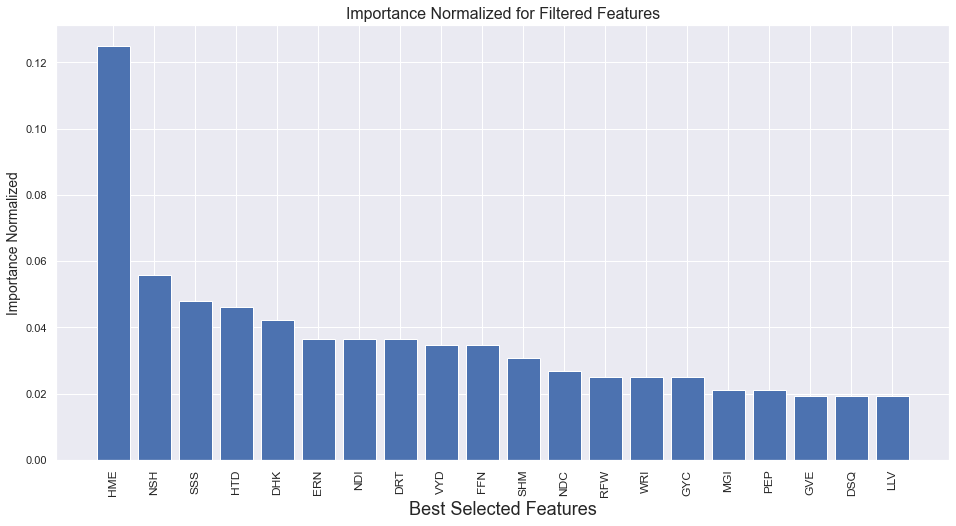

In [53]:
# Create a bar plot of the "Importance Normalized" column
plt.figure(figsize=(16, 8))
plt.bar(top_10_percent['Features'], top_10_percent['Importance Normalized'])

# Increase the font size of the labels and title
plt.xlabel('Best Selected Features', fontsize=18)
plt.ylabel('Importance Normalized', fontsize=14)
plt.title('Importance Normalized for Filtered Features', fontsize=16)

# Rotate the X-axis labels by 45 degrees
plt.xticks(rotation=90, fontsize=12)

plt.show()

### Modify the relative values

In [2]:
df_FeatImp= pd.read_csv("./results/FeatureImportance.csv")

In [3]:
df_FeatImp

,Importance,Features,Importance Normalized
0,0.007320,HME,0.125000
1,0.003266,NSH,0.055769
2,0.002815,SSS,0.048077
3,0.002703,HTD,0.046154
4,0.002477,DHK,0.042308
...,...,...,...
195,-0.000676,HNK,-0.011538
196,-0.000676,IKL,-0.011538
197,-0.000676,VQT,-0.011538
198,-0.000788,DHS,-0.013462


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Create a Min-Max Scaler object
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
df_FeatImp['NormImportance'] = scaler.fit_transform(df_FeatImp[['Importance']])

In [11]:
df_FeatImp

,Importance,Features,Importance Normalized,NormImportance
0,0.007320,HME,0.125000,1.000000
1,0.003266,NSH,0.055769,0.500000
2,0.002815,SSS,0.048077,0.444444
3,0.002703,HTD,0.046154,0.430556
4,0.002477,DHK,0.042308,0.402778
...,...,...,...,...
195,-0.000676,HNK,-0.011538,0.013889
196,-0.000676,IKL,-0.011538,0.013889
197,-0.000676,VQT,-0.011538,0.013889
198,-0.000788,DHS,-0.013462,0.000000


In [13]:
df_FeatImp.to_csv('./results/newFeatureImportance.csv', index=False)

In [15]:
first_20_rows = df_FeatImp.head(20)
first_20_rows

,Importance,Features,Importance Normalized,NormImportance
0,0.007320,HME,0.125000,1.000000
1,0.003266,NSH,0.055769,0.500000
2,0.002815,SSS,0.048077,0.444444
3,0.002703,HTD,0.046154,0.430556
4,0.002477,DHK,0.042308,0.402778
5,0.002140,ERN,0.036538,0.361111
6,0.002140,NDI,0.036538,0.361111
7,0.002140,DRT,0.036538,0.361111
8,0.002027,VYD,0.034615,0.347222
9,0.002027,FFN,0.034615,0.347222


In [16]:
first_20_rows.to_csv('./results/newFeatureImportance10percent.csv', index=False)

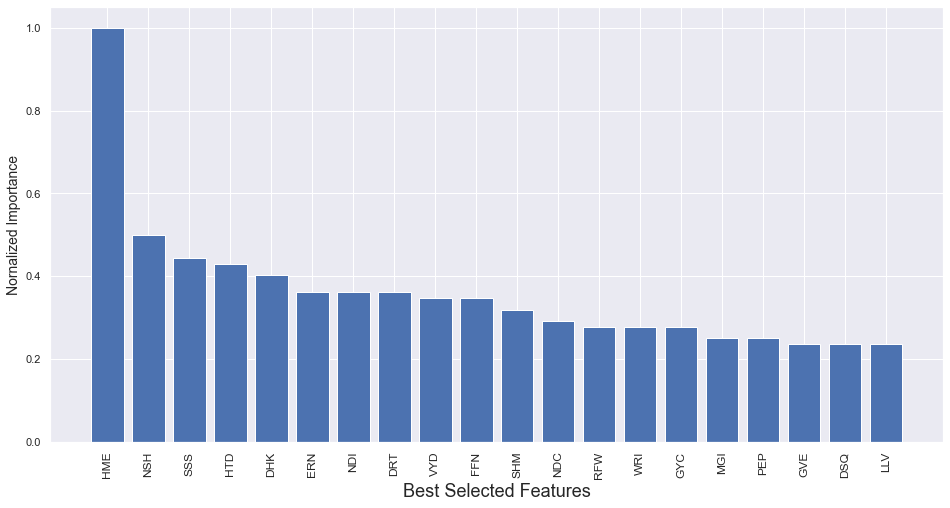

In [17]:
# Create a bar plot of the "Importance Normalized" column
plt.figure(figsize=(16, 8))
plt.bar(first_20_rows['Features'], first_20_rows['NormImportance'])

# Increase the font size of the labels and title
plt.xlabel('Best Selected Features', fontsize=18)
plt.ylabel('Nornalized Importance', fontsize=14)
# plt.title('Importance Normalized for Filtered Features', fontsize=16)

# Rotate the X-axis labels by 45 degrees
plt.xticks(rotation=90, fontsize=12)

plt.show()